### Data import

In [1]:
from os import listdir
from os.path import isfile, join
import torch
import numpy as np
import scipy.linalg
from torchvision.io import read_video
from torchvision.transforms import Grayscale, Resize, Normalize, Compose, ConvertImageDtype
#video_path = "../../../data/VIRAT_CCTV/"
video_path = "yt_video/"
video_files = [video_path + f for f in listdir(video_path) if isfile(join(video_path, f))]
num_frames = 100.
frames, _, _ = read_video(video_files[0], start_pts=3., end_pts=num_frames, pts_unit='sec')
#Apply grayscale transform
frames = frames.permute(0,3,1,2)

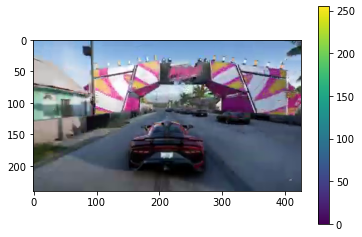

In [2]:
import matplotlib.pyplot as plt
plt.imshow(frames.permute(0,2,3,1)[0])
plt.colorbar()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append("../../")
from DynamicalSystems.kernels import Linear
from DynamicalSystems.reduced_rank_regression import KoopmanRegression
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm

class NetFeatureMap(nn.Module):
    def __init__(self):
      super(NetFeatureMap, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, 3, 1)
      self.conv2 = nn.Conv2d(32, 64, 3, 1)
      self.f1 = nn.Linear(98368, 512)
      self.f2 = nn.Linear(512, 256)

    def forward(self, x):
      x = F.max_pool2d(F.relu(self.conv1(x)),2)
      x = F.max_pool2d(F.relu(self.conv2(x)),2)
      x = F.relu(self.f1(x.reshape(-1, 98368)))
      x = self.f2(x)
      return x

In [4]:
reg = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
net = NetFeatureMap().to(device)
loss_history = [1e8]
batch_size = 500
inputs = torch.split(frames, batch_size)

In [5]:
def loss_fn(Phi, reg, backend = 'torch'):
    Phi_X = Phi[:-1]
    Phi_Y = Phi[1:]
    n = Phi.shape[0] - 1
    K_Y = Phi_Y@(Phi_Y.T)
    if backend == 'torch':
        K_reg = Phi_X@(Phi_X.T) + torch.eye(n, dtype=K_Y.dtype, device=Phi.device)*(n*reg)
        L = torch.linalg.cholesky(K_reg) #K_reg = L@L.T
        return torch.trace(torch.cholesky_solve(torch.cholesky_solve(K_Y/n,L),L))
    else:
        K_reg = Phi_X@(Phi_X.T) + np.eye(n, dtype=K_Y.dtype)*(n*reg)
        L = scipy.linalg.cho_factor(K_reg)
        return np.trace(scipy.linalg.cho_solve(L, scipy.linalg.cho_solve(L, K_Y/n)))

def preprocess(batch):
    transforms = Compose(
        [
            Resize(124),
            ConvertImageDtype(torch.float32),
            Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
        ]
    )
    batch = transforms(batch)
    return batch

In [6]:
optimizer = optim.Adam(net.parameters(), lr=0.0000001)
epochs = 500
lss = "N/A"
progress = tqdm(range(epochs), desc=f"Loss: {lss}", unit='Epoch')
for epoch in progress:
    for batch in inputs:
        optimizer.zero_grad()
        batch = preprocess(batch).to(device)
        output = net.forward(batch)
        loss = loss_fn(output, reg)
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())
    lss = np.around(loss.item(), decimals=3)
    progress.set_description(f"Loss: {lss}")
    if loss.item() <= 1e-10:
        break

Loss: 0.033: 100%|██████████| 500/500 [14:08<00:00,  1.70s/Epochs]


Text(0, 0.5, 'Loss')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


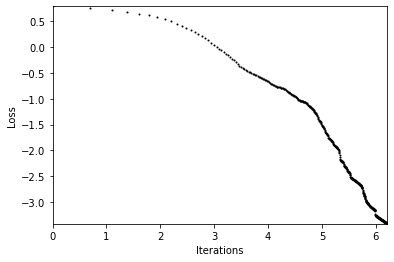

In [7]:
plt.scatter(np.log(np.arange(len(loss_history)-1) + 1),np.log(loss_history[1:]), c='k', s=1)
plt.margins(0)
plt.xlabel("Iterations")
plt.ylabel("Loss")

In [8]:
with torch.no_grad():
    net_cpu = net.to('cpu') #Convert to CPU
    video_frames = preprocess(frames)
    Phi = net_cpu(video_frames)

In [10]:
video_frames = video_frames.numpy()
Phi = Phi.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [16]:
#video_frames = preprocess(frames)
#Phi = net_cpu(video_frames)
_X = np.squeeze(video_frames)
_X = _X.reshape((*_X.shape[:-3], -1))
X = np.squeeze(video_frames[:-1])
X = X.reshape((*X.shape[:-3], -1))
Y = np.squeeze(video_frames[1:])
Y = Y.reshape((*Y.shape[:-3], -1))
Phi_X = Phi[:-1]
Phi_Y = Phi[1:]
kernel = Linear(coef0=0.)
rank = 4

In [17]:
loss_ln = loss_fn(_X, reg, backend = 'numpy').item()
loss_NN = loss_fn(Phi, reg, backend = 'numpy').item()
print(f" Loss NNet:\t{loss_NN}\n Loss Linear:\t{loss_ln}")

 Loss NNet:	0.0010603819973766804
 Loss Linear:	0.011778190732002258


In [18]:
K_NN = KoopmanRegression(Phi_X, Phi_Y, kernel, reg, rank=rank, center_kernel=False, backend='cpu')
K_linear = KoopmanRegression(X, Y, kernel, reg, rank=rank, center_kernel=False, backend='cpu')

INIT: Computing low-rank-projection
INIT: Computing low-rank-projection


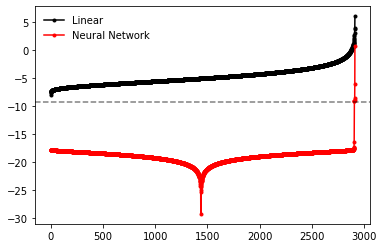

In [19]:
plt.plot(np.log(np.abs(np.linalg.eigvalsh(K_linear.K_X))), 'k.-', label='Linear')
plt.plot(np.log(np.abs(np.linalg.eigvalsh(K_NN.K_X))), 'r.-', label='Neural Network')
plt.axhline(y=np.log(reg), color='k', linestyle='--', alpha=0.5)
plt.legend(frameon=False)

In [30]:
f = lambda _: X
def normalize(x):
    _x = x.transpose(2,3,0,1).real
    _m = (_x.max(axis=(0,1)) + _x.min(axis=(0,1))) / 2 
    _s = _x.max(axis=(0,1)) - _x.min(axis=(0,1))
    _x = (_x - _m) /_s + 0.5
    return 1 - _x.transpose(2,3,0,1)
modes_NN = normalize(K_NN.modes(f).reshape((rank,) + video_frames.shape[1:]))
modes_linear = normalize(K_linear.modes().reshape((rank,) + video_frames.shape[1:]))

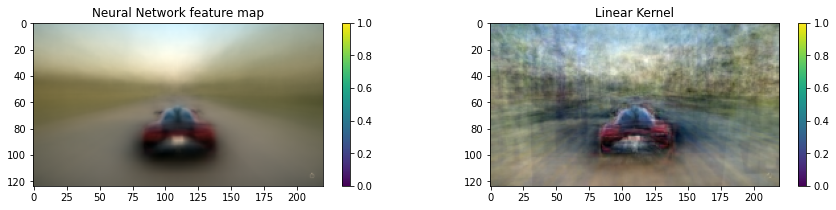

In [33]:
mode_idx = 0
swap_ax = lambda x: np.moveaxis(x, 0, -1)
fig, ax = plt.subplots(1,2, figsize=(15,3))
nn_imshow = ax[0].imshow(swap_ax(modes_NN[mode_idx]))
ax[0].set_title('Neural Network feature map')
fig.colorbar(nn_imshow, ax=ax[0])
lin_imshow = ax[1].imshow(1 - swap_ax(modes_linear[mode_idx].real))
ax[1].set_title('Linear Kernel')
fig.colorbar(lin_imshow, ax=ax[1])

In [95]:
eigs, _, rv = K_NN.eig()
rv = Phi_X.T@rv

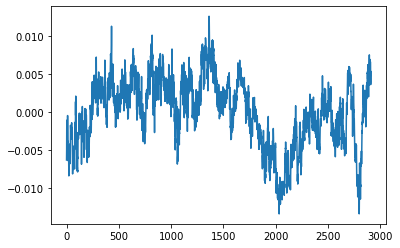

In [96]:
plt.plot(Phi_X@rv[:,1])

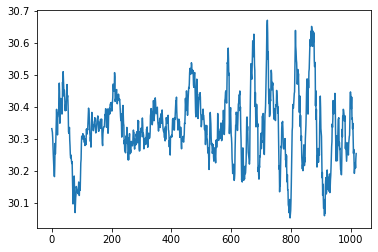

In [28]:
plt.plot(Phi_X@rv[:,0])

In [153]:
eigs

array([0.9996664 +0.j, 0.23024094+0.j], dtype=complex64)